## Курсовой проект к видеокурсу от Megafon

#### Задачи:
- Построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.
- Составление индивидуальных предложений для абонентов

#### Данные:
- data_train.csv: id, vas_id, buy_time, target: информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
- features.csv.zip: id, <feature_list> : нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
- data_test.csv: id, vas_id, buy_time: тестовый набор данных

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц.

<b> Описание данных: </b>
- target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
- buy_time - время покупки, представлено в формате timestamp
- id - идентификатор абонента
- vas_id - подключаемая услуга

#### Метрика:
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).
__________________________________________________________________________________________________________________


## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,\
precision_recall_curve, roc_auc_score, confusion_matrix, make_scorer, roc_curve, auc
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import pickle
import luigi
import gc
from datetime import datetime, date, time
from datetime import timedelta

pd.pandas.set_option('display.max_columns', None)
import warnings
warnings.simplefilter('ignore')

from functions import reduce_mem_usage, get_classification_report, show_feature_importances, \
show_proba_calibration_plots, plot_confusion_matrix

from sklearn.decomposition import PCA
import scipy.sparse
from sklearn.cluster import KMeans

In [2]:
TRAIN_PATH = "/home/yana/projects/megafon/data_train.csv"
TEST_PATH = "/home/yana/projects/megafon/data_test.csv"
FEATURES_PATH = "/home/yana/projects/megafon/features.csv"

In [3]:
data_train = pd.read_csv(TRAIN_PATH)
data_test = pd.read_csv(TEST_PATH)

## Обзор train & test

In [4]:
data_train.head(3)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0


In [5]:
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB
None


In [4]:
#уменьшение потребляемой памяти (из functions.py)
data_train = reduce_mem_usage(data_train)
data_test = reduce_mem_usage(data_test)

Memory usage of the dataframe is 31.73 MB
Memory usage after optimization is: 15.86 MB
Decreased by 50.0%
Memory usage of the dataframe is 2.17 MB
Memory usage after optimization is: 1.09 MB
Decreased by 50.0%


In [7]:
#уникальные значения:
for col in data_train.columns[1:-1]:
    print(f'{col}  -->  {data_train[col].nunique()} + \
    {data_test[~data_test[col].isin(np.unique(data_train[col]))].shape[0]} новых значений в тесте')

id  -->  806613 +     67013 новых значений в тесте
vas_id  -->  8 +     0 новых значений в тесте
buy_time  -->  26 +     71231 новых значений в тесте


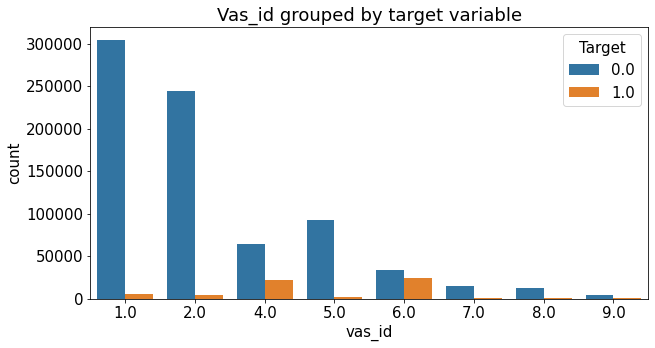

In [8]:
plt.figure(figsize=(10, 5))

sns.countplot(x="vas_id", hue=data_train['target'], data=data_train)
plt.title('Vas_id grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.savefig("vas_id-target2.png")


plt.show()

Из графика выше видно, что различные услуги предлагались разному количеству абонентов, соотношение подключений услуг и отказов также отличается. На следующем графике показано соотношение подключений и отказов вне зависимости от кол-ва предложений абонентам, что впоследствии окажется более полезным признаком для модели

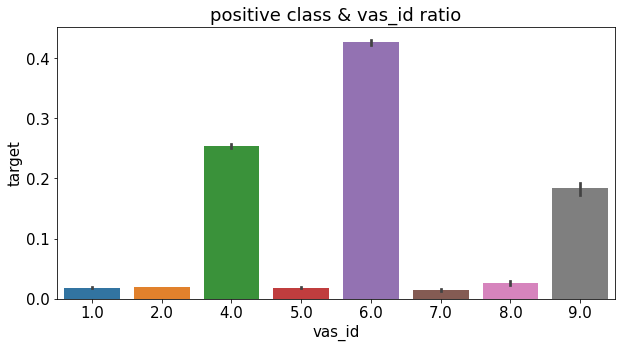

In [9]:
plt.figure(figsize=(10, 5))

sns.barplot("vas_id", 'target', data=data_train)
plt.title('positive class & vas_id ratio')
plt.savefig("vas_id-target.png")
plt.show()

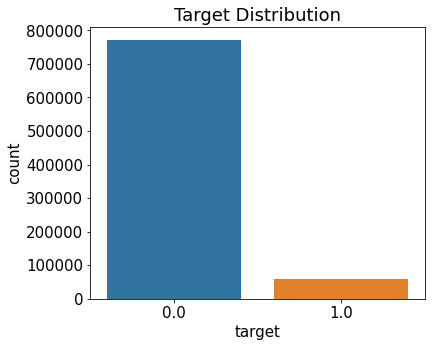

In [10]:
plt.figure(figsize=(6, 5))
plt.title('Target Distribution')

sns.countplot(x='target', data=data_train)
plt.savefig("target.png")

Наблюдается значительный дисбаланс между классами, что может негативно сказаться на результате работы модели.
Добавлять синтетические данные или дубликаты строк миноритарного класса не хочется, т.к. датасет и без того огромный и тяжелый, также могут нарушиться закономерности в датах. Поэтому веса классов принято решение корректировать непосредственно в модели

## Обзор FEATURES

Поскольку датасет весит > 20Гб, сразу уменьшим его и включим только тех пользователей, которые есть в train & test данных.

In [5]:
def process_featues(data_features, train, test):
    ids = np.unique(train['id'].append(test['id']))
    data_features = data_features[data_features['id'].isin(ids)]
    if 'Unnamed: 0' in data_features:
        data_features = data_features.drop(columns='Unnamed: 0')
    
    data_features = data_features.compute()
    # удалим признаки с единственным значением
    df_nunique = data_features.apply(lambda x: x.nunique(dropna=False))
    const = df_nunique[df_nunique ==1].index.tolist()
    data_features = data_features.drop(columns = const)
    return reduce_mem_usage(data_features)

In [6]:
data_features = dd.read_csv(FEATURES_PATH, sep ='\t')
data_features =process_featues(data_features, data_train, data_test)

Memory usage of the dataframe is 1728.06 MB
Memory usage after optimization is: 867.47 MB
Decreased by 49.8%


In [13]:
data_features.corr()

,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,80,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
id,1.000000,0.074840,-0.018533,-0.049811,-0.019042,-0.047225,-0.020980,-0.048451,-0.005416,-0.015210,-0.005240,-0.011587,-0.001216,-0.003679,-0.005242,-0.024060,-0.025880,0.001631,-0.000302,0.000161,-0.012227,0.002342,-0.005751,-0.019417,-0.020158,-0.001046,-0.001341,0.020735,0.031846,-0.012900,-0.016203,-0.019196,-0.018793,-0.026962,-0.001416,-0.001509,-0.013364,0.000576,-0.000429,-0.004331,0.027505,0.021553,0.019050,0.019211,0.025536,-0.013023,-0.015466,-0.008365,0.018783,0.004164,-0.003233,0.000263,-0.012622,-0.011468,-0.010804,-0.016719,-0.001796,-0.002997,-0.003312,0.001372,-0.025255,-0.110329,-0.013646,-0.013864,-0.019514,-0.010480,-0.005025,-0.010429,-0.007208,0.011375,0.007764,0.005213,0.012182,-0.001179,-0.005330,-0.004122,0.003980,0.012869,0.015264,-0.001323,-0.001250,-0.001303,-0.006782,-0.003457,-0.000642,-0.003601,-0.003258,-0.003030,-0.007343,-0.005391,-0.003748,-0.003582,-0.001365,0.000310,-0.000256,0.003758,-0.004141,-0.003020,0.002661,-0.007093,-0.004359,0.001504,-0.001568,0.001929,-0.003048,0.009817,0.000456,-0.009676,-0.005235,0.007548,0.001889,0.021544,0.018987,-0.016944,-0.019235,0.027448,0.046326,-0.005018,-0.000303,0.000020,-0.004364,-0.002011,0.019320,0.025543,0.030714,0.010822,0.018232,-0.007783,-0.004995,-0.020430,-0.024167,-0.003760,0.003719,-0.034033,-0.037130,-0.044315,-0.032439,-0.039517,-0.014309,-0.002940,-0.004201,-0.016217,-0.028622,-0.036792,0.025819,0.006187,-0.006535,0.005164,0.005219,-0.013180,-0.007232,-0.007738,-0.001104,-0.001729,0.003301,0.002257,-0.000686,-0.000811,-0.008449,0.000839,-0.002157,0.002016,-0.022922,0.042078,0.033112,0.053616,0.038834,-0.013305,-0.015462,0.007681,0.003496,-0.008548,-0.004119,-0.007720,-0.007069,-0.004269,-0.002435,-3.572096e-03,-0.003102,0.013457,0.011521,0.023971,0.020969,0.007551,-0.008367,0.019777,0.001264,-0.000113,-0.000828,-0.016292,-0.120043,-0.125707,0.033121,-0.050106,-0.061164,-0.015422,-0.107165,0.004836,-0.008694,-0.038640,0.000844,0.033718,-0.094019,0.000052,-0.044728,0.038582,0.007635,-0.010630,0.002465,-0.014136,0.002705,-0.000216,-0.006314,-6.197861e-04,0.007637,0.002412,0.006283,-0.001107,0.002661,-0.008353,-0.018766,-0.115517,-0.022566,-0.071502,-0.000391,0.004461,0.021617,0.012696,-0.002548,0.001306,0.007481,0.011321,0.006918,0.046921,0.002078,0.025633,0.018830,0.041320,0.033575,0.008622,0.033406,0.031321,0.001759,0.018031,0.016822,0.007157,-0.003176,-0.001042,-0.002227,-0.011229
buy_time,0.074840,1.000000,-0.020798,-0.056733,-0.020246,-0.050396,-0.027111,-0.061522,-0.011254,-0.022163,-0.013326,-0.024264,-0.011507,-0.003426,-0.009533,-0.012718,-0.018461,0.000974,-0.003376,-0.004625,-0.034906,-0.027668,0.000493,-0.025649,-0.007162,-0.001749,-0.002342,0.026137,-0.039176,-0.009274,0.043352,0.052105,0.053781,-0.008408,-0.002343,-0.002728,-0.014717,-0.004623,-0.023212,-0.008936,0.027655,-0.002751,0.036413,-0.010169,0.024222,-0.034550,-0.023695,-0.036358,-0.014749,0.001710,-0.000308,-0.000196,-0.052366,-0.051358,-0.059623,-0.055125,-0.020017,-0.021721,-0.023750,-0.004457,-0.097688,-0.091455,-0.011331,-0.014591,-0.043179,-0.008901,-0.011189,-0.000060,-0.000363,-0

У многих признаков высокий уровень корреляции между собой, поэтому, вероятно, некоторые из них можно удалить.

Ниже посмотрим, насколько отличается статистика по данным признакам в зависимости от значения целевой переменной. Видно, что распределение многих признаков очень сходно: значения 25, 50, 75 перцинтилей одинаковы, средние отличаются незначительно, но есть разница в минимальных и максимальных значениях

In [14]:
tmp = data_train.merge(data_features, on='id', how = 'left')

In [15]:
tmp[tmp.columns[6:]].loc[tmp.target==1].describe() - tmp[tmp.columns[6:]].loc[tmp.target==0].describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,80,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
count,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.00000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-7.356380e+05,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-7.356380e+05,-735638.000000,-735638.000000,-735638.000000,-7.356380e+05,-735638

In [16]:
del tmp

Вывод: желательно выбрать минимальное кол-во признаков, чтобы сделать работу модели менее ресурсозатратной. Вероятнее всего, это будет возможно сделать, т.к. далеко не все признаки репрезентативны

## Подготовка датасета

In [7]:
X = data_train.drop('target', axis=1)
y = data_train['target']

Объединим train и features и добавим новые признаки, создадим пайплайн для обработки датасета. 
Подавляющее большинство дат в features и train не совпадают, различных дат и обновлений профилий в features довольно мало, результат работы модели практически не меняется в зависимости от способа объединения датасетов.

In [8]:
class DataTransform(BaseEstimator, TransformerMixin):

    def __init__(self, features):
        self.data = None
        self.target = None
        self.features = features.copy()
        self.vas_id_dict1 = None
        self.vas_id_dict2 = None
        self.vas_id_dict3 = None
        self.q_list = None
        self.first_day = None


        
    def fit(self, data, target):
        self.data = data.copy()
        self.target = target.astype('int')
        X = pd.concat([data, target], axis=1)
        # доля подключений услуги по сравнению с отказами
        self.vas_id_dict1 = dict(X.groupby('vas_id')['target'].mean())
        # соотношение подключений по всем услугам
        self.vas_id_dict2 = dict(X.loc[X['target']==1]['vas_id'].value_counts(normalize=True))
        # доля предложений услуги
        self.vas_id_dict3 = dict(X['vas_id'].value_counts(normalize=True))
        #максимальные 20% значений по признакам из features
        self.q_list = [np.quantile(self.features[el], q=0.8) for el in self.features][2:]
        self.first_day = data['buy_time'].min()
        

        return self

    
    def transform(self, data):
   
        if 'Unnamed: 0' in data.columns:
            data.drop(columns='Unnamed: 0', inplace=True)
        data = reduce_mem_usage(data)
        
        # при сравнении распределения признаков в зависимости от целевой переменной в таблице выше видно, что
        # наибольшая разница наблюдается верхнем квартиле. Посчитаем значения выше 0.8 квантиля
        self.features['highest_value'] = 0
        for i, col in enumerate(self.features.columns[2:-1]):
            self.features.loc[self.features[col] > self.q_list[i], 'highest_value'] +=1
        
        
        self.features.drop_duplicates('id', keep='first', inplace=True)
        prepared_df = pd.merge(data, self.features, how='left', on='id')
        
        prepared_df.rename(columns={'buy_time_x': 'buy_time'}, inplace=True)
        

        # будем считать кол-во дней с 1го дня train периода
        prepared_df['count_days'] = (prepared_df['buy_time'] - self.first_day) //86400
        
        # доля подключений услуги по сравнению с отказами
        prepared_df['vas_id1'] = prepared_df['vas_id'].replace(self.vas_id_dict1)
        
        #prepared_df['vas_id2'] = prepared_df['vas_id'].replace(self.vas_id_dict2)
        #prepared_df['vas_id3'] = prepared_df['vas_id'].replace(self.vas_id_dict3)
       # prepared_df['date'] = prepared_df['buy_time'].apply(lambda x: date.fromtimestamp(x))
       # prepared_df['month'] = prepared_df['buy_time'].apply(lambda x: date.fromtimestamp(x).month)
        prepared_df['day'] = prepared_df['buy_time'].apply(lambda x: date.fromtimestamp(x).day)
        prepared_df['weekofyear'] = prepared_df['buy_time'].apply(lambda x: pd.to_datetime(date.fromtimestamp(x)).weekofyear)
        
        
        """
        Некоторым пользователям сделано несколько предложений. Сохраним информацию, какую услугу пользователю
        уже предлагали (каждую отдельно), сколько у него всего предложений, в какой последовательности предлагали
        услуги, какая разница по времени между предложениями услуг
        
        """
        tmp = prepared_df[['id', 'buy_time', 'vas_id']].merge(self.data[['id', 'buy_time', 'vas_id']],\
                                                              on=['id', 'buy_time', 'vas_id'], how='outer')
        tmp = tmp.loc[tmp['id'].isin(prepared_df['id'])]
        tmp2 = tmp.groupby('id')['vas_id'].count().reset_index()
        tmp2 = tmp2.loc[tmp2['vas_id']>1]
        tmp['buy_time'] = (tmp['buy_time'] - self.first_day) //86400
        tmp.rename(columns={'buy_time': 'count_days'}, inplace=True)
        # будем считать предложения только для тех пользователей, у которых их больше 1
        tmp = tmp.loc[tmp['id'].isin(tmp2['id'])].sort_values(['id', 'count_days']).reset_index(drop=True)
        tmp['1.0'] = 0 
        tmp['2.0'] = 0
        tmp['4.0'] = 0
        tmp['5.0'] = 0
        tmp['6.0'] = 0
        tmp['7.0'] = 0
        tmp['8.0'] = 0
        tmp['9.0'] = 0
        
        checked_id = 0
        counter = 1
        tmp['count_offers'] = 1
        tmp['time_delta'] = 0

        for i in range(tmp.shape[0]):
            if tmp.iloc[i]['id'] != checked_id:
                checked_id = tmp.iloc[i]['id']
                counter = 1   
            else:
                counter +=1
                tmp.loc[i, 'count_offers'] = counter
                tmp.loc[i, 'time_delta'] = tmp.iloc[i]['count_days'] - tmp.iloc[i-1]['count_days']
            tmp.loc[i, str(tmp.iloc[i]['vas_id'])] +=1
                
        prepared_df = prepared_df.merge(tmp[['id', 'vas_id','count_days', 'count_offers','time_delta']],\
                                        on=['id', 'vas_id','count_days'], how='left')
        prepared_df = prepared_df.merge(tmp.groupby('id').agg({'1.0': 'sum', '2.0':'sum', '4.0': 'sum', 
                    '5.0':'sum', '6.0': 'sum', '7.0':'sum', '8.0': 'sum', '9.0':'sum'}).reset_index(), on='id', how='left')
        
        #остальным пользователям проставим 1 предложение
        prepared_df['count_offers'] = prepared_df['count_offers'].fillna(1)
        prepared_df['time_delta'] = prepared_df['time_delta'].fillna(0)
        prepared_df['1.0'] = prepared_df['1.0'].fillna(0).rename('offer_1')
        prepared_df['2.0'] = prepared_df['2.0'].fillna(0).rename('offer_2')
        prepared_df['4.0'] = prepared_df['4.0'].fillna(0).rename('offer_4')
        prepared_df['5.0'] = prepared_df['5.0'].fillna(0).rename('offer_5')
        prepared_df['6.0'] = prepared_df['6.0'].fillna(0).rename('offer_6')
        prepared_df['7.0'] = prepared_df['7.0'].fillna(0).rename('offer_7')
        prepared_df['8.0'] = prepared_df['8.0'].fillna(0).rename('offer_8')
        prepared_df['9.0'] = prepared_df['9.0'].fillna(0).rename('offer_9')

        
        prepared_df.drop(['id','buy_time'], axis=1, inplace=True)
        
               
        
        return prepared_df
        

Изначально в пайплайн подавались все имеющиемя данные, но многие признаки оказались незначимыми для модели. Поскольку данные анонимизированы и нормализованы, сложно понять, какие из них являются категориальными и не имеют количественной взаимосвязи. Пробовала считатать признаки с < 10 уникальных значений категориальными, с 2мя значениями - бинарными. 

В итоге лучший результат получился, если посчитать все анонимизированные признаки из features количественными и воспользоваться методом pca. За несколько итераций удалось значительно сократить кол-во признаков без потери качества. За 1 итерацию качественно сократить кол-во признаков до минимума не получилось, поскольку в разных сочетаниях у них разные веса, сразу из 250 признаков выделить 10 главных компонент получилось не очень хорошо. 

Итого оставим:
- 1 категориальный признак
- 10 количественных признаков после РСА
- новые фичи оставим без изменений

In [56]:
#df_nunique = data_features.apply(lambda x: x.nunique(dropna=False))
#bool_features = df_nunique[df_nunique ==2].index.tolist()
#cat_features = df_nunique[df_nunique <=10].index.tolist()
#num_features = np.setdiff1d(data_features.columns[2:], cat_features)
#cat_features = np.append(np.setdiff1d(cat_features, bool_features),'vas_id')
#other_features = ['highest_value', 'count_days', 'vas_id1', 'day', 'weekofyear', 'count_offers',
#       'time_delta', '1.0', '2.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

In [9]:
num_features = data_features.columns[2:]
cat_features = ['vas_id']
bool_features = []
other_features = ['highest_value', 'count_days', 'vas_id1', 'day', 'weekofyear', 'count_offers',
       'time_delta', '1.0', '2.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

In [10]:
class PCA_transformer(BaseEstimator, TransformerMixin):

    def __init__(self, num_features):
        self.num_features = num_features
        # постепенно сократим кол-во компонент до 10
        self.steps = [80, 40, 25, 15, 10]
        self.X = None

    def fit(self, X, y=None):
        self.X = X.copy()
        return self

    def transform(self, X, y=None):
        data = X[self.num_features].copy()
        for step in self.steps:
            pca = PCA(n_components=step, svd_solver='full')
            data = pca.fit_transform(data)
        col_names = ['pca' + str(i) for i in range(len(data[0]))]

        return X.join(pd.DataFrame(data, columns=col_names))   

In [11]:
# обработка признаков разного типа в пайплайне

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)
    
    
class Bool_col(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.mode = None
        self.unique = None
        
    def fit(self, X, y=None):
        self.mode = X.mode()[0]
        self.unique = np.unique(X)
        return self
    
    def transform(self, X, y=None):
        for el in X:
            if el not in self.unique:
                el = self.mode
        zero = self.unique[0]
        X = np.where(X==zero, 0, 1)
        return X.reshape(len(X), 1)

In [12]:
pca_features = ['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9']

In [13]:
final_transformers = list()

#for col in bool_features:
#    bool_transformer = Pipeline([
#                ('selector', ColumnSelector(column=col)),
#                ('bool', Bool_col(key=col))
#            ])
#    final_transformers.append((col, bool_transformer))
    
cat_transformer = Pipeline([
                ('selector', ColumnSelector(cat_features)),
                ('ohe', OneHotEncoder(handle_unknown='ignore'))
            ])
final_transformers.append(('cat', cat_transformer))
    
num_transformer = Pipeline([
                ('selector', ColumnSelector(pca_features))
            ])

final_transformers.append(('num', num_transformer))
    

other_transformer = Pipeline([
                ('selector', ColumnSelector(other_features))
            ])

final_transformers.append(('other', other_transformer))

In [14]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [15]:
# пайплайн для подготовки датасета, пока без классификатора
prep_pipeline = Pipeline([
   ('prepare', DataTransform(data_features)),
    ('pca_transformer', PCA_transformer(data_features.columns[2:])),
    ('features',feats)
])

In [16]:
prep_pipeline.fit(X, y)
data = prep_pipeline.transform(X)

Memory usage of the dataframe is 9.52 MB
Memory usage after optimization is: 9.52 MB
Decreased by 0.0%
Memory usage of the dataframe is 9.52 MB
Memory usage after optimization is: 9.52 MB
Decreased by 0.0%


In [30]:
#сохраню полученные данные
cols = ['vas1', 'vas2', 'vas4', 'vas5', 'vas6', 'vas7', 'vas8', 'vas9', *pca_features, *other_features]
df = pd.DataFrame.sparse.from_spmatrix(data, columns = cols)
df['id'] = data_train['id']

In [31]:
df.to_csv('data/data.csv', index=False)

## Обучение и выбор модели

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=13)

Рассмотрим и сравним 3 модели:
- XGBClassifier
- CatBoostClassifier
- LGBMClassifier

Подбор параметров осуществлялся с помощью GridsearchCV. Вот один из примеров:

In [35]:
parameters = [{'max_depth': [11,12, 13] , 
               'n_estimators': [80, 100, 120],
               'num_leaves': [100, 121, 144],
               'learning_rate':[0.01, 0.045], 
               'reg_lambda': [0.2, 0.4,]}]

gridsearch = GridSearchCV(estimator= LGBMClassifier(objective='binary',
                     scale_pos_weight = 1.7935), param_grid=parameters,  
                          scoring=make_scorer(f1_score, average='macro'), cv=5)

In [36]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(objective='binary',
                                      scale_pos_weight=1.7935),
             param_grid=[{'learning_rate': [0.01, 0.045],
                          'max_depth': [11, 12, 13],
                          'n_estimators': [80, 100, 120],
                          'num_leaves': [100, 121, 144],
                          'reg_lambda': [0.2, 0.4]}],
             scoring=make_scorer(f1_score, average=macro))

In [39]:
gridsearch.best_params_

{'learning_rate': 0.045,
 'max_depth': 13,
 'n_estimators': 100,
 'num_leaves': 100,
 'reg_lambda': 0.2}

Обучение моделей с уже подобранными параметрами:

In [33]:
%%time

model_xgb = XGBClassifier(n_estimators=425,
                          max_depth=6,
                          learning_rate=0.005,
                          reg_lambda=0.8,
                          reg_alpha=0.8,
                          scale_pos_weight=3,
                          random_state=13,
                          eval_metric='logloss',
                          importance_type='weight')
model_xgb.fit(X_train, y_train)

CPU times: user 1h 29s, sys: 2.68 s, total: 1h 32s
Wall time: 5min 47s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='weight',
              interaction_constraints='', learning_rate=0.005, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=425, n_jobs=16,
              num_parallel_tree=1, random_state=13, reg_alpha=0.8,
              reg_lambda=0.8, scale_pos_weight=3, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
xgb_train_proba = model_xgb.predict_proba(X_train)[:, 1]
xgb_test_proba = model_xgb.predict_proba(X_test)[:, 1]

In [35]:
get_classification_report(y_train, xgb_train_proba,
                          y_test, xgb_test_proba, threshold=0.55)

TRAIN

              precision    recall  f1-score   support

         0.0    0.97594   0.95458   0.96514    578600
         1.0    0.54536   0.69838   0.61246     45139

    accuracy                        0.93604    623739
   macro avg    0.76065   0.82648   0.78880    623739
weighted avg    0.94478   0.93604   0.93962    623739

TEST

              precision    recall  f1-score   support

         0.0    0.97581   0.95458   0.96508    192867
         1.0    0.54479   0.69675   0.61147     15047

    accuracy                        0.93592    207914
   macro avg    0.76030   0.82567   0.78828    207914
weighted avg    0.94462   0.93592   0.93949    207914



In [36]:
%%time

model_cb = CatBoostClassifier(silent=True, iterations=160, learning_rate=0.03, depth=7, l2_leaf_reg=4, 
                                auto_class_weights='Balanced', eval_metric='F1', early_stopping_rounds=50, 
                              random_state=42)
model_cb.fit(X_train, y_train)

CPU times: user 4min 37s, sys: 9.81 s, total: 4min 46s
Wall time: 21.3 s


In [37]:
cb_train_proba = model_cb.predict_proba(X_train)[:, 1]
cb_test_proba = model_cb.predict_proba(X_test)[:, 1]

In [38]:
get_classification_report(y_train, cb_train_proba,
                          y_test, cb_test_proba, threshold=0.83)

TRAIN

              precision    recall  f1-score   support

         0.0    0.97590   0.95443   0.96505    578600
         1.0    0.54438   0.69784   0.61163     45139

    accuracy                        0.93587    623739
   macro avg    0.76014   0.82614   0.78834    623739
weighted avg    0.94467   0.93587   0.93947    623739

TEST

              precision    recall  f1-score   support

         0.0    0.97579   0.95447   0.96501    192867
         1.0    0.54405   0.69642   0.61088     15047

    accuracy                        0.93579    207914
   macro avg    0.75992   0.82544   0.78794    207914
weighted avg    0.94454   0.93579   0.93938    207914



In [18]:
%%time

model_lgb = LGBMClassifier(objective='binary',
                     max_depth=13,
                     n_estimators=100,
                     num_leaves = 100,
                     learning_rate=0.045,
                     scale_pos_weight = 1.7935,
                     reg_lambda = 0.2)

model_lgb.fit(X_train, y_train)

CPU times: user 1min 8s, sys: 89.8 ms, total: 1min 8s
Wall time: 4.52 s


LGBMClassifier(learning_rate=0.045, max_depth=13, num_leaves=100,
               objective='binary', reg_lambda=0.2, scale_pos_weight=1.7935)

In [19]:
lgb_train_proba = model_lgb.predict_proba(X_train)[:, 1]
lgb_test_proba = model_lgb.predict_proba(X_test)[:, 1]

In [20]:
get_classification_report(y_train, lgb_train_proba,
                          y_test, lgb_test_proba, threshold=0.49)

TRAIN

              precision    recall  f1-score   support

         0.0    0.97044   0.96910   0.96977    578600
         1.0    0.61077   0.62157   0.61612     45139

    accuracy                        0.94395    623739
   macro avg    0.79060   0.79533   0.79294    623739
weighted avg    0.94441   0.94395   0.94417    623739

TEST

              precision    recall  f1-score   support

         0.0    0.97006   0.96908   0.96957    192867
         1.0    0.60871   0.61660   0.61263     15047

    accuracy                        0.94357    207914
   macro avg    0.78939   0.79284   0.79110    207914
weighted avg    0.94391   0.94357   0.94374    207914



In [121]:
predictions = {'XGBoost': xgb_test_proba, 'CatBoost': cb_test_proba, 'LGBM': lgb_test_proba}

XGBoost : AUC_PR = 0.706
XGBoost : AUC_ROC = 0.953
CatBoost : AUC_PR = 0.702
CatBoost : AUC_ROC = 0.955
LGBM : AUC_PR = 0.711
LGBM : AUC_ROC = 0.956


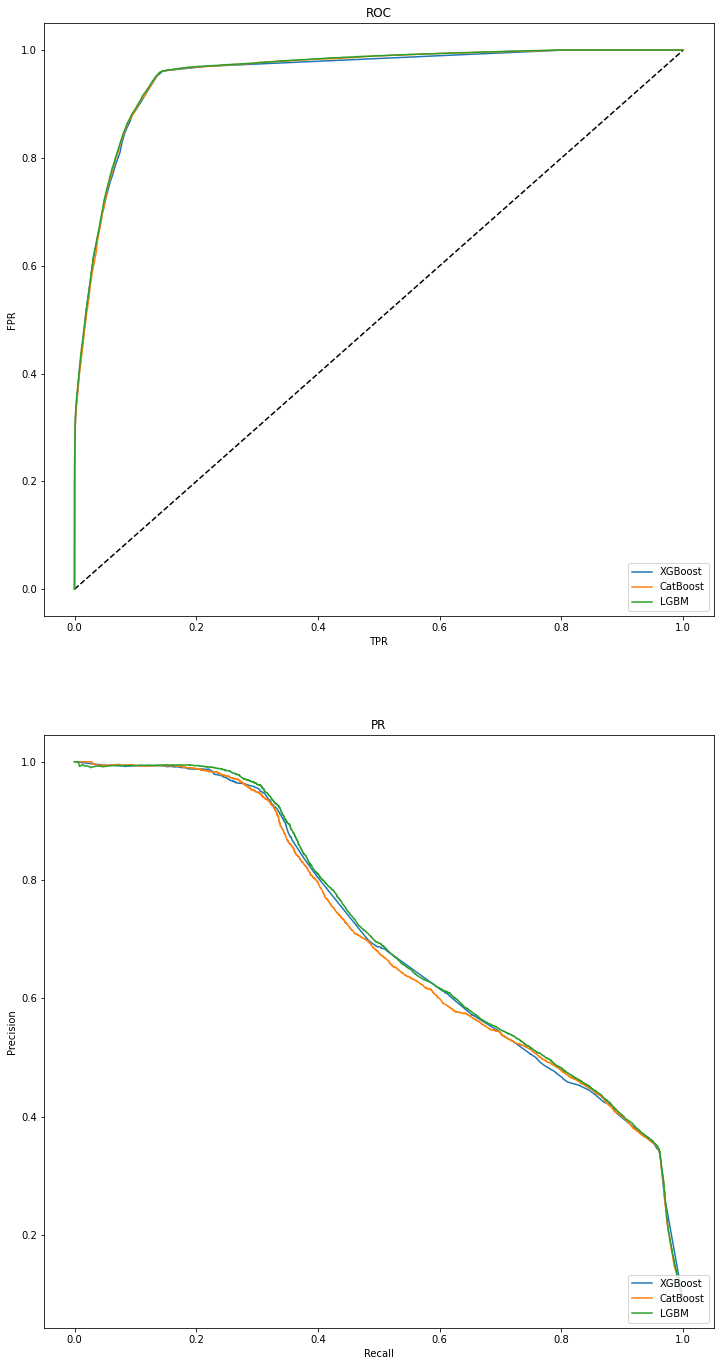

In [122]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

for key, value in predictions.items():
    fpr, tpr, roc_thresholds = roc_curve(y_test, value)
    precision, recall, pr_thresholds = precision_recall_curve(y_test, value)
    ax1.plot(fpr, tpr, label=key)
    ax2.plot(recall, precision, label=key)
    print(key, ": AUC_PR = %.3f" % auc(recall, precision))
    print(key, ": AUC_ROC = %.3f" % auc(fpr, tpr))
    
    
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");
plt.savefig("roc-pr.png")

Результаты работы всех моделей довольно схожи. Выбор сделан в пользу LGBM, т.к. это наименее ресурсозатратная модель, что особенно важно при обработке такого большого количества данных 

In [21]:
cols = ['vas1', 'vas2', 'vas4', 'vas5', 'vas6', 'vas7', 'vas8', 'vas9', *pca_features, *other_features]

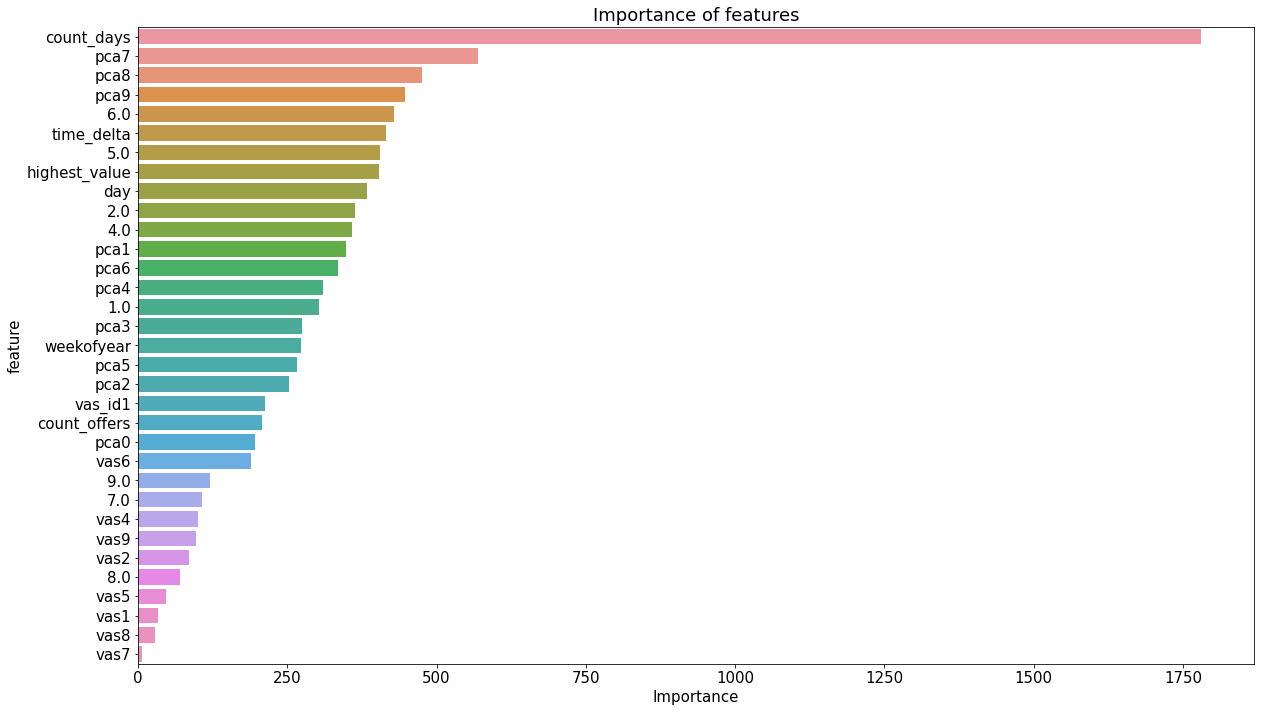

In [33]:
important_features_top = show_feature_importances(cols, model_lgb.feature_importances_, get_top=None)

In [34]:
# Проверим работу модели с помощью кросс-валидации:
cv_scores = cross_val_score(model_lgb, data, y, cv=6, scoring=make_scorer(f1_score, average='macro'))
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))


CV score is 0.7897464054891187+-0.006064508575946133


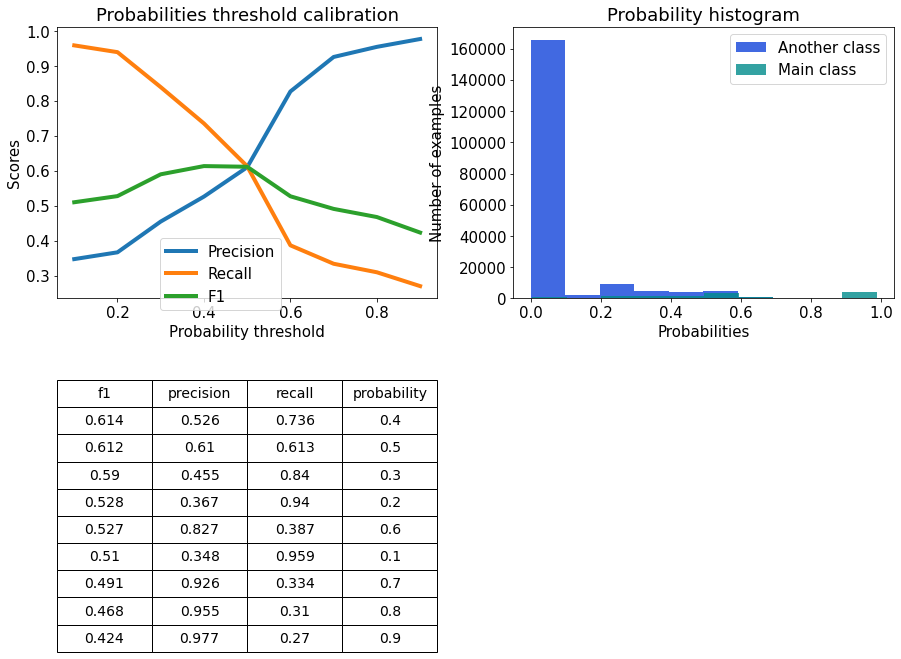

In [36]:
show_proba_calibration_plots(lgb_test_proba, y_test)

Confusion matrix, without normalization
[[186903   5964]
 [  5769   9278]]


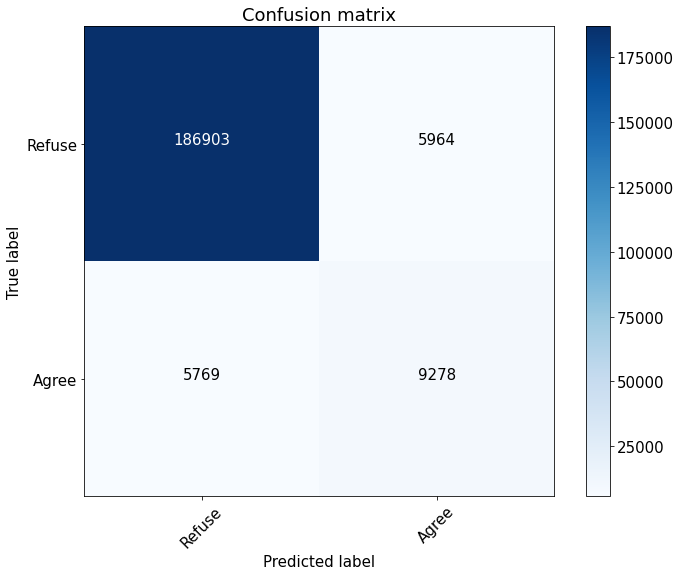

In [38]:
cnf_matrix = confusion_matrix(y_test, lgb_test_proba>0.49)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Refuse', 'Agree'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## Cохранение пайплайна

In [40]:
full_pipeline = Pipeline([
    ('prepare', DataTransform(data_features)),
    ('pca_transformer', PCA_transformer(data_features.columns[2:])),
    ('features',feats),
    ('classifier', LGBMClassifier(objective='binary',
                     max_depth=13,
                     n_estimators=100,
                     num_leaves = 100,
                     learning_rate=0.045,
                     scale_pos_weight = 2.86,
                     reg_lambda = 0.2))
])

full_pipeline.fit(X, y)

Memory usage of the dataframe is 9.52 MB
Memory usage after optimization is: 9.52 MB
Decreased by 0.0%


Pipeline(steps=[('prepare',
                 DataTransform(features=           id    buy_time           0            1           2            3  \
13    2046132  1534712400  300.820038  1599.480835  286.879211  1585.013184   
16    2050810  1540760400  -86.209969    91.820885  -84.480789   110.333199   
19    2070757  1540760400  -96.799973  -408.179108 -110.740784  -460.786804   
20    2071522  1544994000  -94.939972  -363.699127 -108.880783  -411.226807   
22    2075318  1533502800  -75.639969   669.690918  -89...
                                                                                          'pca9']))])),
                                                ('other',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(columns=['highest_value',
                                                                                          'count_days',
                           

In [41]:
lgb_train_proba = full_pipeline.predict_proba(X)[:, 1]

Memory usage of the dataframe is 9.52 MB
Memory usage after optimization is: 9.52 MB
Decreased by 0.0%


In [42]:
print(classification_report(y, lgb_train_proba > 0.49))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96    771467
         1.0       0.51      0.77      0.62     60186

    accuracy                           0.93    831653
   macro avg       0.75      0.86      0.79    831653
weighted avg       0.95      0.93      0.94    831653



In [42]:
with open("models/lgbm_pipeline.pickle", "wb") as f:
    pickle.dump(full_pipeline, f)

## Запись результата

In [43]:
class PredictProbability(luigi.Task):
    
    test_csv = luigi.Parameter()
    
  
    
    def run(self):
        
        test = pd.read_csv(self.test_csv, float_precision="high", encoding='utf8',sep=',')
        
      
        with open('models/lgbm_pipeline.pickle', 'rb') as model_file:
            model = pickle.load(model_file)
        

        test['target'] = model.predict_proba(test)[:, 1]
        
        
        test.to_csv('answers_test.csv', float_format='%20f', index=False, encoding='utf8',sep=',')
        
  

    def output(self):
        return luigi.LocalTarget('answers_test.csv')


In [50]:
if __name__ == '__main__':
    luigi.build([PredictProbability('data_test.csv')])

DEBUG: Checking if PredictProbability(test_csv=data_test.csv) is complete
INFO: Informed scheduler that task   PredictProbability_data_test_csv_b958939509   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 2406] Worker Worker(salt=157352751, workers=1, host=yana-VivoBook-ASUSLaptop-X521UA-M533UA, username=yana, pid=2406) running   PredictProbability(test_csv=data_test.csv)


Memory usage of the dataframe is 1.63 MB
Memory usage after optimization is: 0.82 MB
Decreased by 50.0%


INFO: [pid 2406] Worker Worker(salt=157352751, workers=1, host=yana-VivoBook-ASUSLaptop-X521UA-M533UA, username=yana, pid=2406) done      PredictProbability(test_csv=data_test.csv)
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   PredictProbability_data_test_csv_b958939509   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=157352751, workers=1, host=yana-VivoBook-ASUSLaptop-X521UA-M533UA, username=yana, pid=2406) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 ran successfully:
    - 1 PredictProbability(test_csv=data_test.csv)

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



In [2]:
answers = pd.read_csv('answers_test.csv')
answers.head(5)

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0.001050
1,2000860,4.0,1548018000,0.401209
2,1099444,2.0,1546808400,0.001006
3,1343255,5.0,1547413200,0.000809
4,1277040,2.0,1546808400,0.000991


______________

## Персональные предложения пользователям

Каким абонентам имеет смысл предлагать услугу? Выше я определила оптимальный порог для f1-macro - 0.49. Теперь посмотрим, какой порог будет оптимальным для увеличения f1 именно по миноритарному (позитивному) классу:

In [31]:
precision, recall, thresholds = precision_recall_curve(y_test, lgb_test_proba)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix], roc_auc_score(y_test, lgb_test_proba)))

Best Threshold=0.423339, F-Score=0.615, Precision=0.538, Recall=0.718, Roc_auc=0.956


In [32]:
confusion_matrix(y_test, lgb_test_proba>0.423339)

array([[183604,   9263],
       [  4243,  10804]])

С точки зрения чисто ML-задачи оптимальным порогом для определения, звонить абоненту или нет, будет 0.42334
Но помимо этого важно учесть экономические и маркетинговые приоритеты компании на данном этапе. Если компании важно охватить как можно больше клиентов, не упустить никого (увеличить recall), то порог следует снизить. Если же комапния не намерена тратить ресурсы на большое количество клиентов и заинтересована в том, чтобы ML-алгоритм макимально точно показал только тех клиентов, которые с максимальной вероятностью воспользуются услугой (увелилчить precision), порог следует повысить. Для того, чтобы предложить клиенту услугу, компании придется потратить деньги, поэтому обзванивать всех клиентов зачастую нецелесообразно. Чтобы определить, какой именно порог будет наиболее выгодным, можно подсчитать затраты на кандидата и прибыль с каждого true positive клиента.  

В качестве упрощенного примера предположим, что затраты на кандидата = 1 доллар, а прибыль с true positive клиента = 2 доллара. Количество пороговых значений thresholds уменьшу для экономии времени

In [46]:
expenses = 1
profit = 2
thresholds = np.linspace(0.3, 0.8, 51)

In [47]:
max_revenue = 0
best_t = 0
for t in thresholds:
    cnf_matrix = confusion_matrix(y_test, lgb_test_proba>t)
    add_summ = cnf_matrix[1,1]*profit - np.sum(cnf_matrix[:,1])*expenses
    if add_summ > max_revenue:
        max_revenue = add_summ
        best_t = t
print(f'Максимальный доход: {max_revenue} достигнут при пороге {best_t}')

Максимальный доход: 4682 достигнут при пороге 0.63


Возможно, если пользователь не согласится на эту конкретную услугу, его заинтересует другая.

Если поставить задачу определить, какая из 8 указанных услуг больше подойдет пользователю, то можно попробовать ее решить с помощью мультиклассовой классификации, используя признак "vas_id" в качестве целефой переменной. Возьмем предобработанные в пайплайне выше данные из data_train.csv и уберем оттуда новые признаки, зависящие непосредственно от 'vas_id'.

In [54]:
df = pd.read_csv('data/data.csv')

In [55]:
df = df.drop(['vas1', 'vas2', 'vas4', 'vas5', 'vas6', 'vas7', 'vas8', 'vas9', '1.0', '2.0', '4.0', '5.0', '6.0', '7.0',
 '8.0', '9.0', 'vas_id1'], axis=1)

In [56]:
df['vas_id'] = data_train['vas_id']

In [57]:
df.head(3)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,highest_value,count_days,day,weekofyear,count_offers,time_delta,id,vas_id
0,7.991845e+08,-705038592.0,-123991016.0,-7721.062500,39407.078125,-2455.243164,-54935.652344,10521.842773,-606.962280,-2279.649414,40.0,70.0,17.0,38.0,1.0,0.0,540968,8.0
1,1.218484e+09,746919488.0,-193242928.0,42764.742188,-50241.210938,3925.911377,-15401.685547,-6934.932129,-5702.692383,-420.344269,23.0,7.0,16.0,29.0,1.0,0.0,1454121,4.0
2,-6.787158e+08,-264372512.0,-85790240.0,-130304.742188,118672.812500,-10253.279297,-60936.457031,-6358.357422,-6196.040527,-758.487610,5.0,35.0,13.0,33.0,1.0,0.0,2458816,1.0


In [58]:
#разделим пользователей на кластеры
k8 = KMeans(n_clusters=8, precompute_distances = True, n_jobs=-1)
k8.fit(df)
df['kmeans'] =k8.predict(df)

In [59]:
result = LabelEncoder()
y = result.fit_transform(data_train['vas_id'])

In [60]:
# для обучения возьмем только пользователей, подключивших услугу
df['target'] = data_train['target']
df['vas_id'] = y

df_train = df.loc[df.target==1]

In [61]:
X = df_train.drop(['vas_id', 'target'], axis=1)
y = df_train['vas_id']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=13)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(45139, 18) (45139,) (15047, 18) (15047,)


In [63]:
X_id = X_test['id']
X_train = X_train.drop('id', axis=1)
X_test = X_test.drop('id', axis=1)

In [64]:
%%time

model_lgb = LGBMClassifier(objective='multiclass',
                     max_depth=10,
                     n_estimators=200,
                     num_leaves = 100,
                     learning_rate=0.045,
                     class_weight = 'balanced',
                     reg_lambda = 0.2)

model_lgb.fit(X_train, y_train)

CPU times: user 2min 59s, sys: 625 ms, total: 3min
Wall time: 11.4 s


LGBMClassifier(class_weight='balanced', learning_rate=0.045, max_depth=10,
               n_estimators=200, num_leaves=100, objective='multiclass',
               reg_lambda=0.2)

In [65]:
preds = model_lgb.predict_proba(X_test)

In [66]:
df_preds = pd.DataFrame(preds, columns = ['1','2','4', '5','6','7','8', '9'])
df_preds['best_service'] = [df_preds.iloc[row].idxmax() for row in range(df_preds.shape[0])]
df_preds['id'] = X_id.values
df_preds = df_preds[['id', 'best_service','1','2','4', '5','6','7','8', '9' ]]


In [67]:
df_preds.best_service.value_counts(normalize=True)

6    0.395693
4    0.252476
1    0.119825
2    0.116568
5    0.057752
9    0.043663
8    0.009969
7    0.004054
Name: best_service, dtype: float64

Не удивительно, что распределение получилось именно таким: наибольший процент подключений у услуги 6, вторая по привлекательности - услуга № 4, как и в первоначальном датасете data_train.csv., а по подключению услуг 7, 8 и 9 довольно мало наблюдений. 

In [68]:
data_train[data_train.target==1]['vas_id'].value_counts()

6.0    24704
4.0    21765
1.0     5664
2.0     4797
5.0     1692
9.0     1004
8.0      347
7.0      213
Name: vas_id, dtype: int64

Итак, если мы хотим подобрать оптимальную услугу, к примеру, для пользователя 862975, то это услуга № 8    

In [69]:
df_preds.loc[df_preds['id']==862975]

,id,best_service,1,2,4,5,6,7,8,9
7898,862975,8,0.071377,0.102699,0.044177,0.064554,0.005465,0.009075,0.618215,0.084439


Если идем от обратного и ищем, каким пользователям продать услугу № 1, то ниже наиболее подходящие кандидаты:

In [70]:
df_preds.sort_values('1', ascending=False).head(3)

,id,best_service,1,2,4,5,6,7,8,9
12613,218982,1,0.825566,0.025207,0.070083,0.059486,0.016506,0.000236,0.001379,0.001536
8097,3861301,1,0.818405,0.037825,0.079476,0.038456,0.023145,0.000149,0.000575,0.001970
9431,1302155,1,0.800923,0.019336,0.119856,0.024347,0.031750,0.000219,0.000817,0.002752


Если решать данную задачу в качестве бинарной классификации (взять выборку и включить в нее одинаковые данные о пользователях, но со всеми возможными 'vas_id', то окажется, что некоторым пользователям не интересны никакие услуги, а другим интересны сразу несколько

In [71]:
X_train = pd.concat([df, pd.get_dummies(data_train['vas_id'].astype('str'))], axis=1).drop(['target', 'vas_id', 'id'], axis=1)
y_train = df['target']

In [72]:
X_test['vas_id'] = 1

In [73]:
part = X_test.copy()
part['vas_id'] = 2
X_test = X_test.append(part)
part['vas_id'] = 4
X_test = X_test.append(part)
part['vas_id'] = 5
X_test = X_test.append(part)
part['vas_id'] = 6
X_test = X_test.append(part)
part['vas_id'] = 7
X_test = X_test.append(part)
part['vas_id'] = 8
X_test = X_test.append(part)
part['vas_id'] = 9
X_test = X_test.append(part)

X_test = pd.concat([X_test, pd.get_dummies(X_test['vas_id'].astype('str'))], axis=1)


In [74]:
results = pd.DataFrame()
results['id'] = np.append(X_id, [X_id, X_id, X_id, X_id, X_id, X_id, X_id])
results['vas_id'] = X_test['vas_id'].values

X_test.drop('vas_id', axis = 1, inplace=True)

In [75]:
model_lgb = LGBMClassifier(objective='binary',
                     max_depth=13,
                     n_estimators=100,
                     num_leaves = 100,
                     learning_rate=0.045,
                     scale_pos_weight = 2.86,
                     reg_lambda = 0.2)

model_lgb.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.045, max_depth=13, num_leaves=100,
               objective='binary', reg_lambda=0.2, scale_pos_weight=2.86)

In [76]:
binary_preds = model_lgb.predict_proba(X_test)[:, 1]

In [77]:
results['preds']= binary_preds
results.head(5)

,id,vas_id,preds
0,1946568,1,0.039547
1,3951560,1,0.034299
2,367758,1,0.001166
3,817454,1,0.985663
4,1421442,1,0.001145


In [78]:
results.loc[results['id']==817454]

,id,vas_id,preds
3,817454,1,0.985663
15050,817454,2,0.985663
30097,817454,4,0.985366
45144,817454,5,0.985663
60191,817454,6,0.985010
75238,817454,7,0.985663
90285,817454,8,0.985663
105332,817454,9,0.985663


In [76]:
results.loc[results['id']==1946568]

,id,vas_id,preds
0,1946568,1,0.040037
15047,1946568,2,0.054159
30094,1946568,4,0.397937
45141,1946568,5,0.020599
60188,1946568,6,0.694334
75235,1946568,7,0.032917
90282,1946568,8,0.038390
105329,1946568,9,0.048339


Таким образом, сложность в решении задачи о персональных предложениях в том, что
- наблюдается значительный дисбаланс между кол-вом предложений разных услуг
- Не понятно, что считать за оптимально подобранную пару пользователь-услуга. Если пользователь подключил услугу, возможно, другую он подключил бы охотнее.

Определение, с какими пользователями имеет смысл взаимодействовать, возможно с помощью решения задачи UPLIFT. Некоторые клиенты негативно воспринимают любое взаимодействие с ними ("спящие собаки"), другие лояльны и без дополнительных затрат на их удержание. 

Также мне стало интересно попробовать решение по принципу рекомендательных систем с помощью библиотеки imlicit, но в рамках наших данных этот вариант не работает. Вероятно, он бы сработал, если бы у нас было больше пользователей с несколькими разными услугами

In [79]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

In [80]:
user_item_matrix = pd.pivot_table(data_train,
                                          index='id',
                                          columns='vas_id',
                                          values='target',
                                          aggfunc='sum',
                                          fill_value=0
                                          )
user_item_matrix = user_item_matrix.astype(float)

In [81]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [82]:
model = AlternatingLeastSquares(factors=100,
                                        regularization=0.1,
                                        iterations=8,
                                        num_threads=15,
                                        calculate_training_loss=True)
model.fit(csr_matrix(user_item_matrix).T.tocsr())

  0%|          | 0/8 [00:00<?, ?it/s]

In [83]:
def get_recommendations(user, model, N=2):
    res = [(id_to_itemid[rec[0]], rec[1]) for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=csr_matrix(user_item_matrix),
                                    N=N, 
                                    filter_already_liked_items=True, 
                                    filter_items=False, 
                                    recalculate_user=True)]
    return res

In [84]:
get_recommendations(342, model=model, N=1)

[(7.0, -0.0011231120102969533)]

In [85]:
data_train.loc[data_train.id ==342]

,Unnamed: 0,id,vas_id,buy_time,target
14041,14041,342,1.0,1541365200,0.0
14042,14042,342,2.0,1542574800,1.0


Вариант не сработал в данном случае, пользователю рекомендуется услуга c нулевой вероятностью. Но при большем кол-ве разных услуг вариант мог бы быть интереснее